# Grid Search with SIREN using Alpine

---


This example demonstrates how to use the **Alpine** library to perform a grid search for hyperparameter tuning on a SIREN (Sinusoidal Representation Network) model applied to image data.

We first use Alpine to load and preprocess an image, then define the SIREN model architecture. We will then set up a grid search to explore different hyperparameter combinations, train the model, and evaluate its performance using metrics such as PSNR and SSIM.

## Tip: Use GPU Acceleration
If you are running this notebook in Google Colab, navigate to `Runtime > Change runtime type` and select `GPU` as the hardware accelerator. This will significantly speed up the training process.

## Steps in this example:
In this example we will:
- Load and preprocess an image using Alpine.
- Define a SIREN model architecture.
- Set up a grid search for hyperparameter tuning.
- Train the model and evaluate its performance using PSNR and SSIM metrics.
- Visualize the results of the best model.

## Install Alpine
Alpine can be installed from the source repository. We run the following command to install Alpine and its dependencies.


In [1]:
!git clone https://github.com/kushalvyas/alpine.git
%cd alpine
!pip3 install -e .

fatal: destination path 'alpine' already exists and is not an empty directory.
/content/alpine
Obtaining file:///content/alpine
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for alpine (pyproject.toml) ... done
  Created wheel for alpine: filename=alpine-1.0.0-0.editable-py3-none-any.whl size=5787 sha256=dae4baf94496a6a53e283f193e336cbd04c9780c6c3d52c68c33e9e32c85aae2
  Stored in directory: /tmp/pip-ephem-wheel-cache-rj9b2p9v/wheels/ca/d1/78/a5eb8581748ef06612b3f2eef282305dcde95ec8fddbc6b1ef
Successfully built alpine
  Attempting uninstall: alpine
    Found existing installation: alpine 1.0.0
    Uninstalling alpine-1.0.0:
      Successfully uninstalled alpine-1.0.0



---

## Preparing the dataset
First, let's load the image we will use! For this example, we will use a sample image from the `skimage` library. We will also preprocess the image to normalize its pixel values.

In [2]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics import MetricTracker

from matplotlib import pyplot as plt
from tqdm import tqdm
import skimage.transform

from alpine.models import Siren
from alpine.dataloaders import NDSignalLoader
from alpine.metrics import SSIM
from alpine.models.utils import get_coords_spatial
from alpine.utils.grid_search import GridSearch

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


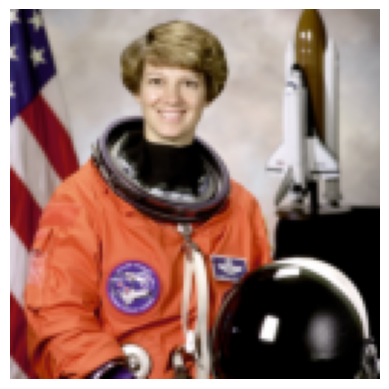

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

img_res = (128, 128) # Image resolution (downsampled for speed)

coords = get_coords_spatial(img_res[0], img_res[1]).cuda()[None,...]

gt_img = skimage.transform.resize(skimage.data.astronaut(), img_res)
gt = torch.from_numpy(gt_img).float().to(device)

image_cpu = gt.cpu().numpy()
plt.imshow(image_cpu)
plt.axis('off')
plt.show()

---

## Setting up grid search parameters
Next, we will define the hyperparameter grid for our grid search. We will explore different combinations of hidden features and epochs to find the best configuration for our SIREN model.

We first set the model parameters. The in and out features are fixed for image data, but we will vary the hidden features and number of layers. 

Alpine also supports different learning rate schedulers and optimizers, which can be passed into the ```compile_params``` dictionary. We will keep these fixed for this example, but they can also be included in the grid search.

Finally, we create a `GridSearch` object, passing in the model class, model parameters, compile parameters, number of iterations, and device.

In [4]:
# 1. Define Parameter Grids
# Lists for variables, lists of length 1 for constants
model_grid = {
    'hidden_features': [32, 64, 128],  # Trying 3 sizes
    'hidden_layers': [2, 3],           # Trying 2 depths
    'in_features': [2],                # Constant
    'out_features': [3],               # Constant
    'omegas': [[30.0]]                 # Constant list-of-lists
}

compile_grid = {
    'optimizer_name': ['adam'],
    'learning_rate': [1e-3, 1e-4]      # Trying 2 learning rates
}

iterations = [1000, 2000]               # Trying short vs medium training

# 2. Initialize Searcher
searcher = GridSearch(
    model_class=Siren,
    model_params=model_grid,
    compile_params=compile_grid,
    n_iters=iterations,
    device=device,
    save_path="siren_tuning_results.csv"
)


Next we set up metric trackers that will be used to evaluate model performance during training. We will use PSNR and SSIM as our evaluation metrics.

In [5]:
metric_trackers = {
    'psnr' : MetricTracker(PeakSignalNoiseRatio(data_range=1.0).to(device)),
    'ssim' : MetricTracker(SSIM(signal_shape=img_res).to(device)),
}

Next, we run the grid search to train models with different hyperparameter combinations. The grid search will evaluate each model using the specified metrics and keep track of the best-performing model. 

In [6]:
print("Starting Grid Search...")
results = searcher.run(coords, gt[None,...], verbose=True)
print("Done!")

Starting Grid Search...
Starting 24 runs on cuda. Saving to siren_tuning_results.csv


Grid Search:   0%|          | 0/24 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 32, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 64, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 2, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:1000


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Running: Arch:{'hidden_features': 128, 'hidden_layers': 3, 'in_features': 2, 'out_features': 3, 'omegas': [30.0]} | Opt:{'optimizer_name': 'adam', 'learning_rate': 0.0001} | Iters:2000


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Done!


---

## Analyzing results

After the grid search is complete, we can analyze the results to find the best hyperparameter combination. We will print out the best parameters and visualize the reconstructed image from the best model.

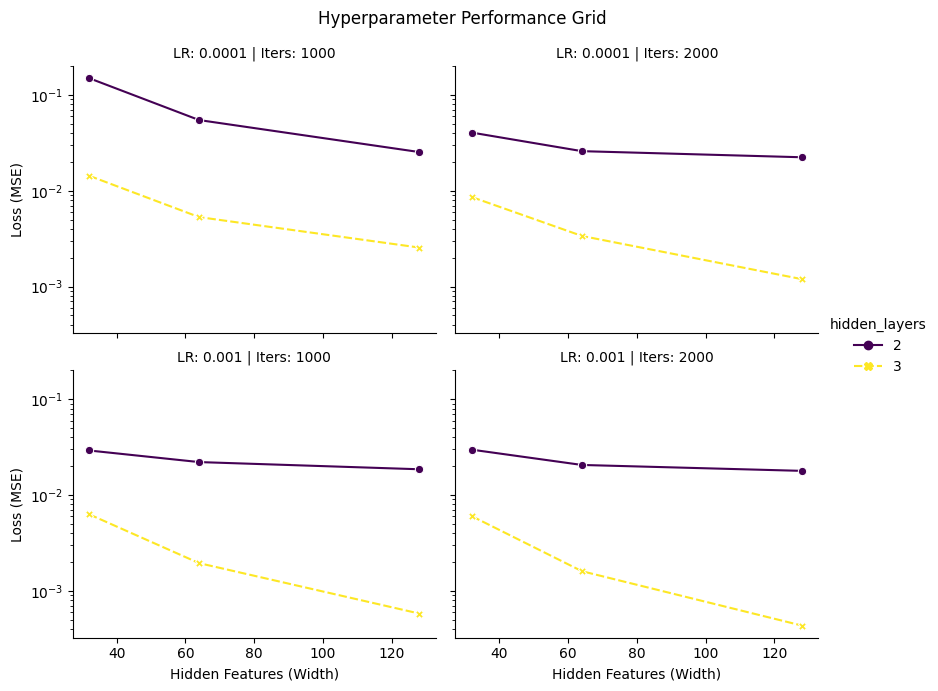

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df = searcher.get_results_df() 

# Create a grid of plots
# Rows = Learning Rate, Columns = Iterations
g = sns.relplot(
    data=df,
    x="hidden_features", 
    y="loss",
    hue="hidden_layers",      # Color lines by depth
    style="hidden_layers",    # Different markers for depth
    col="n_iters",            # Split columns by iterations
    row="learning_rate",      # Split rows by learning rate
    kind="line",              # Use lines to show trends
    markers=True,
    height=3.5, 
    aspect=1.2,
    palette="viridis"
)

# Improvements
g.set_axis_labels("Hidden Features (Width)", "Loss (MSE)")
g.set_titles("LR: {row_name} | Iters: {col_name}")
plt.yscale('log')
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Hyperparameter Performance Grid")
plt.show()

We can then visualize the results of the best model by reconstructing the image and displaying it alongside the ground truth image.

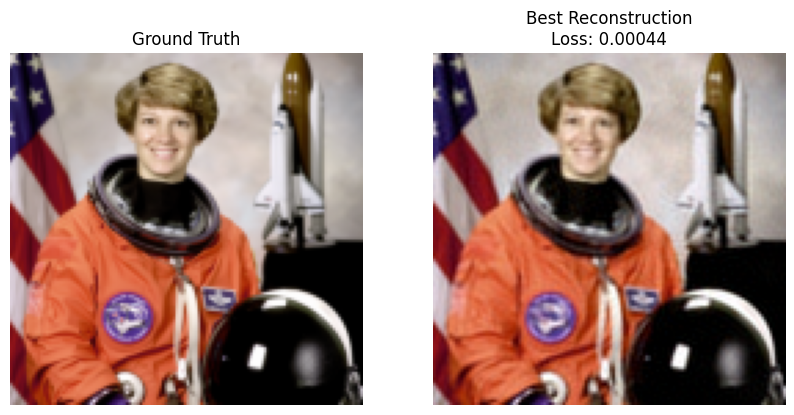

In [14]:
best_model = searcher.get_best_model().to(device)
with torch.no_grad():
    # [Batch, Pixels, 3]
    output = best_model(coords)['output'][0, :, :]
    
    pred_img = output.reshape(img_res[0], img_res[1], 3).cpu().numpy().clip(0, 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gt_img)
ax[0].set_title("Ground Truth")
ax[0].axis('off')

ax[1].imshow(pred_img)
ax[1].set_title(f"Best Reconstruction\nLoss: {searcher.best_loss:.5f}")
ax[1].axis('off')
plt.show()